In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import joblib # Para salvar o modelo final
import os

sns.set(style="whitegrid")
%matplotlib inline

# Caminhos
PROCESSED_DATA_PATH = "../data/processed"
MODELS_PATH = "../models"

os.makedirs(MODELS_PATH, exist_ok=True)

In [2]:
train_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/train.csv")
test_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/test.csv")

print("Dados carregados!")
print(f"Treino: {train_df.shape}")
print(f"Teste: {test_df.shape}")

# Separando X e y
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']

X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

Dados carregados!
Treino: (227845, 31)
Teste: (56962, 31)


In [3]:
print("Distribuição antes do SMOTE:")
print(y_train.value_counts())

# Aplicando SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nDistribuição DEPOIS do SMOTE:")
print(y_train_res.value_counts())

Distribuição antes do SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64

Distribuição DEPOIS do SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [4]:

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_res, y_train_res)

print("Modelo de Regressão Logística treinado com sucesso.")

Modelo de Regressão Logística treinado com sucesso.


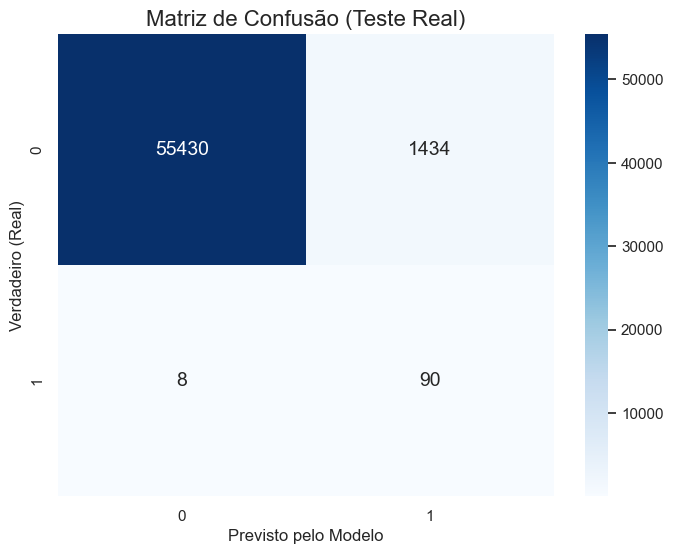

In [5]:
y_pred = model.predict(X_test)

# Matriz
cm = confusion_matrix(y_test, y_pred)

# Visualização bonita
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.title("Matriz de Confusão (Teste Real)", fontsize=16)
plt.ylabel("Verdadeiro (Real)")
plt.xlabel("Previsto pelo Modelo")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



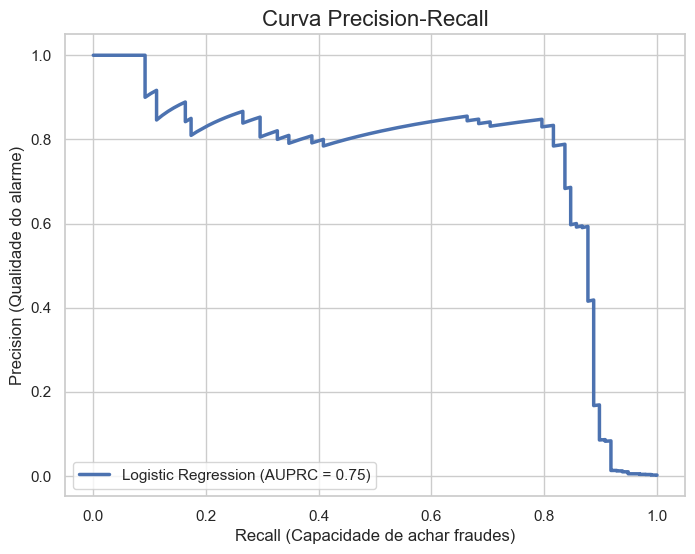

In [6]:

print(classification_report(y_test, y_pred))

# Calculando a curva Precision-Recall
y_score = model.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
auprc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Logistic Regression (AUPRC = {auprc:.2f})', linewidth=2.5)
plt.xlabel('Recall (Capacidade de achar fraudes)', fontsize=12)
plt.ylabel('Precision (Qualidade do alarme)', fontsize=12)
plt.title('Curva Precision-Recall', fontsize=16)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [7]:
filename = f"{MODELS_PATH}/logreg_smote_v1.pkl"
joblib.dump(model, filename)
print(f"Modelo salvo em: {filename}")

Modelo salvo em: ../models/logreg_smote_v1.pkl


In [10]:
#Trocando para Random Forest
from sklearn.ensemble import RandomForestClassifier

# Criando o modelo
# n_estimators=100: Cria 100 árvores de decisão
# n_jobs=-1: Usa todos os núcleos do seu processador para ir mais rápido
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Treinando nos dados com SMOTE
print("Treinando Random Forest...")
rf_model.fit(X_train_res, y_train_res)

print("Random Forest treinado!")

Treinando Random Forest...
Random Forest treinado!


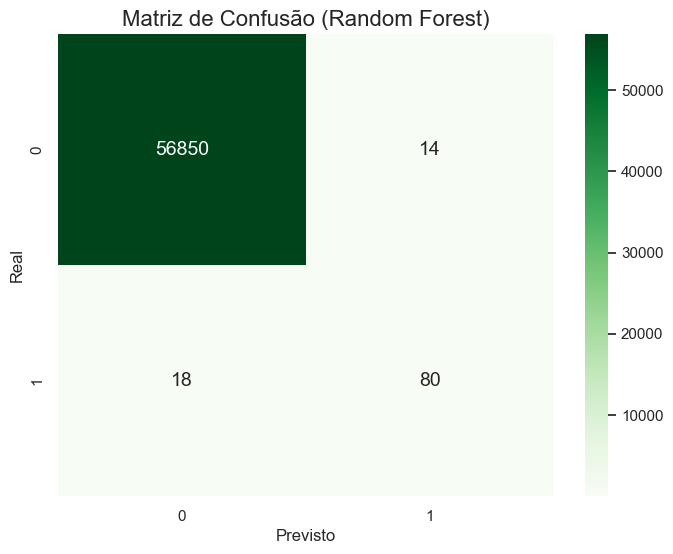


--- Relatório Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Nova AUPRC: 0.8685


In [11]:
#Avaliação do Random Forest
y_pred_rf = rf_model.predict(X_test)

# Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 14})
plt.title("Matriz de Confusão (Random Forest)", fontsize=16)
plt.ylabel("Real")
plt.xlabel("Previsto")
plt.show()

# Relatório Completo
print("\n--- Relatório Random Forest ---")
print(classification_report(y_test, y_pred_rf))

# AUPRC
y_score_rf = rf_model.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_score_rf)
auprc_rf = auc(recall_rf, precision_rf)

print(f"Nova AUPRC: {auprc_rf:.4f}")